# Data Cleaning and EDA for project 2 Web APIs and NLP

The project report is available [here](https://git.generalassemb.ly/sumakarnam/dsir-82/blob/master/projects/project3/Code/Project%203%20%20-%20Final%20Report.ipynb). 

Using [Pushshift's](https://github.com/pushshift/api) API, 2000+ posts were scraped from the following subreddits:

- [r/languagelearning](https://www.reddit.com/r/languagelearning/)
- [r/linguistics](https://www.reddit.com/r/linguistics/)

The code for scraping data is available in this [notebook](https://git.generalassemb.ly/sumakarnam/dsir-82/blob/master/projects/project3/Code/Scraping%20Reddit%20data.ipynb)


In this notebook, the scraped reddit data is cleaned by discarding any posts that were removed or had no content except for the title. This data is exported to a [.csv file](https://git.generalassemb.ly/sumakarnam/dsir-82/blob/master/projects/project3/Data/reddit_data_clean.csv). 

This notebook also includes an EDA of the numerical features of the scraped data (character and word counts of the title and text of the post and number of comments). As the distributions of these numerical features were similar for both the subreddits, only the text data is used to classify the posts. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#import reddit data

ll = pd.read_csv('../Data/languagelearning.csv') 
lg = pd.read_csv('../Data/linguistics.csv')


In [3]:
#creating a single dataframe with all the data

data = pd.concat([ll, lg], ignore_index=True)

for x in ['languagelearning','linguistics']:
    data[data['subreddit'] == x]['created_utc'].min()

#dropping posts with no self text

data.dropna(subset = ['selftext'], inplace=True)

#dropping posts that were removed

data = data[~data['selftext'].str.contains('\[removed\]')].reset_index(drop = True)

data.shape
data.groupby('subreddit').count()

1625535612

1618933648

(4036, 6)

,title,selftext,created_utc,author,num_comments
subreddit,,,,,
languagelearning,2015,2015,2015,2015,2015
linguistics,2021,2021,2021,2021,2021


In [4]:
#adding word count and char count of the tile and selftext to the DataFrame

data['post_word_count'] = data['selftext'].apply(lambda x : len(x.split()))
data['post_char_count'] = data['selftext'].apply(len)
data['title_char_count'] = data['title'].apply(len)
data['title_word_count'] = data['title'].apply(lambda x : len(x.split()))

In [5]:
#saving the DataFrame as .csv

#data.to_csv('../Data/reddit_data_clean.csv', index=False)

In [6]:
data.groupby('subreddit').describe().T

subreddit               languagelearning   linguistics
created_utc      count      2.015000e+03  2.021000e+03
                 mean       1.627805e+09  1.624461e+09
                 std        1.440926e+06  3.377084e+06
                 min        1.625537e+09  1.618934e+09
                 25%        1.626569e+09  1.621476e+09
                 50%        1.627701e+09  1.624399e+09
                 75%        1.629033e+09  1.627429e+09
                 max        1.630453e+09  1.630445e+09
num_comments     count      2.015000e+03  2.021000e+03
                 mean       1.539553e+01  1.483028e+01
                 std        3.296659e+01  3.496042e+01
                 min        0.000000e+00  0.000000e+00
                 25%        3.000000e+00  2.000000e+00
                 50%        6.000000e+00  5.000000e+00
                 75%        1.400000e+01  1.300000e+01
                 max        4.150000e+02  4.630000e+02
post_word_count  count      2.015000e+03  2.021000e+03
                 mean       1.105722e+02  1.028496e+02
                 std        1.198847e+02  1.421107e+02
                 min        1.000000e+00  1.000000e+00
                 25%        4.200000e+01  3.700000e+01
                 50%        7.800000e+01  6.900000e+01
                 75%        1.380000e+02  1.170000e+02
                 max        1.636000e+03  3.147000e+03
post_char_count  count      2.015000e+03  2.021000e+03
                 mean       6.273474e+02  6.205641e+02
                 std        6.890058e+02  8.780425e+02
                 min        1.000000e+00  9.000000e+00
                 25%        2.385000e+02  2.200000e+02
                 50%        4.400000e+02  4.150000e+02
                 75%        7.705000e+02  7.100000e+02
                 max        9.800000e+03  2.036400e+04
title_char_count count      2.015000e+03  2.021000e+03
                 mean       5.375831e+01  6.322118e+01
                 std        3.400106e+01  4.177394e+01
                 min        4.000000e+00  4.000000e+00
                 25%        3.100000e+01  3.500000e+01
                 50%        4.600000e+01  5.300000e+01
                 75%        6.800000e+01  8.000000e+01
                 max        2.960000e+02  2.980000e+02
title_word_count count      2.015000e+03  2.021000e+03
                 mean       9.061042e+00  1.024245e+01
                 std        6.131199e+00  7.403946e+00
                 min        1.000000e+00  1.000000e+00
                 25%        5.000000e+00  5.000000e+00
                 50%        8.000000e+00  8.000000e+00
                 75%        1.200000e+01  1.300000e+01
                 max        5.600000e+01  6.600000e+01

### Visualizations of the content of the two subreddits

In [22]:
data.columns

Index(['subreddit', 'title', 'selftext', 'created_utc', 'author',
       'num_comments', 'post_word_count', 'post_char_count',
       'title_char_count', 'title_word_count'],
      dtype='object')

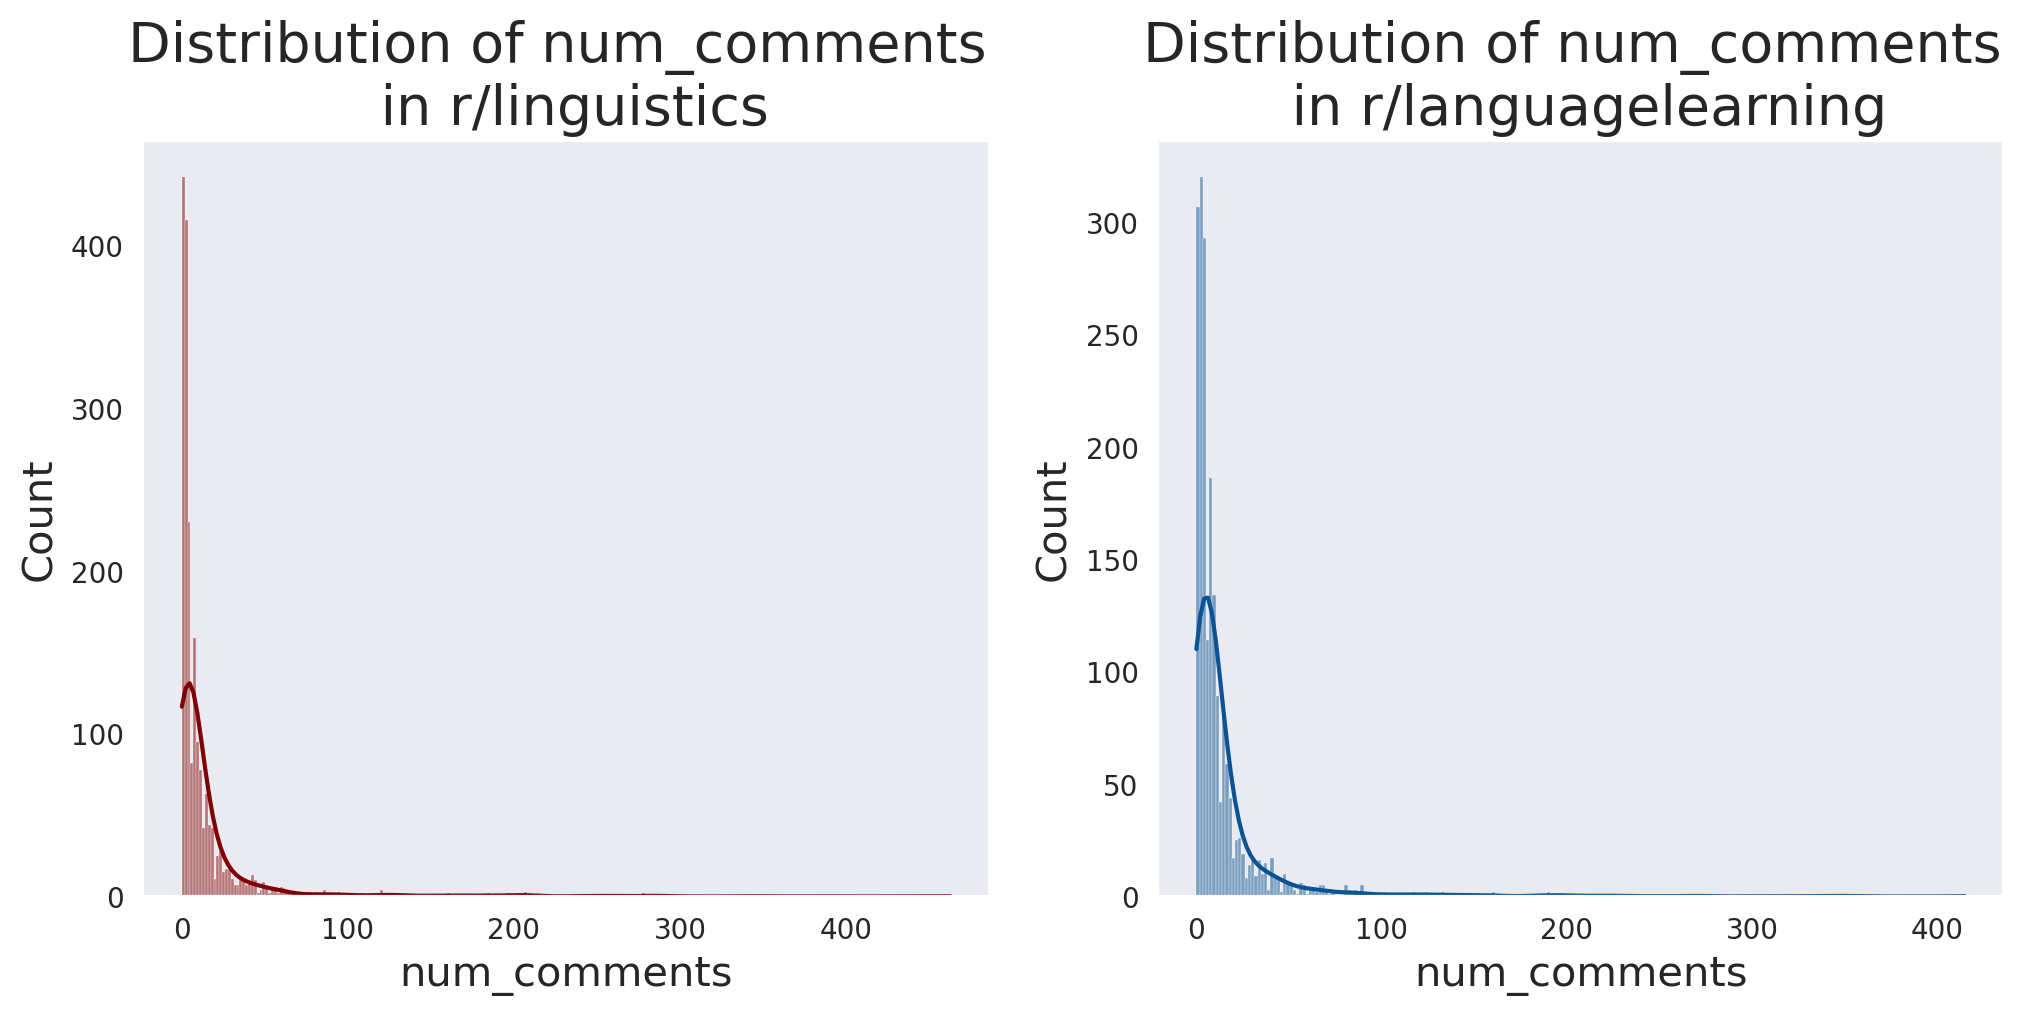

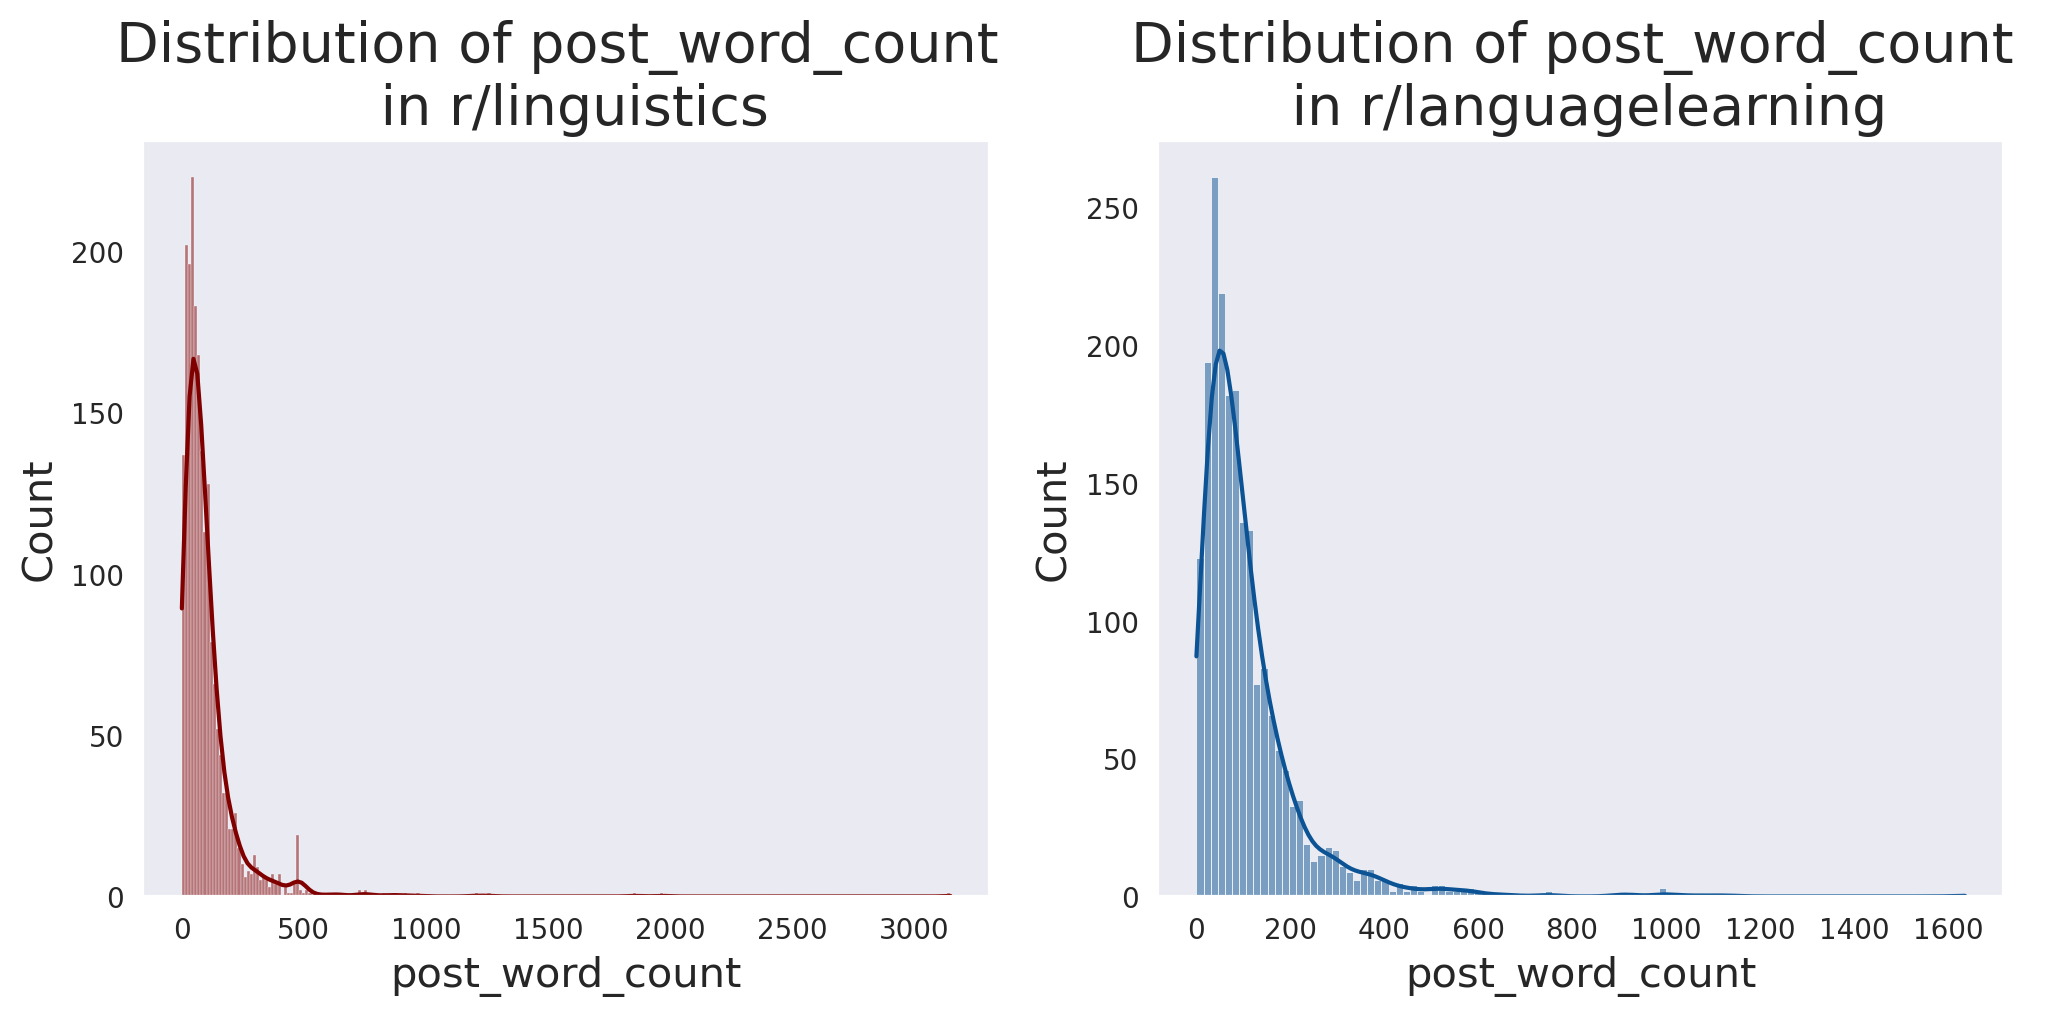

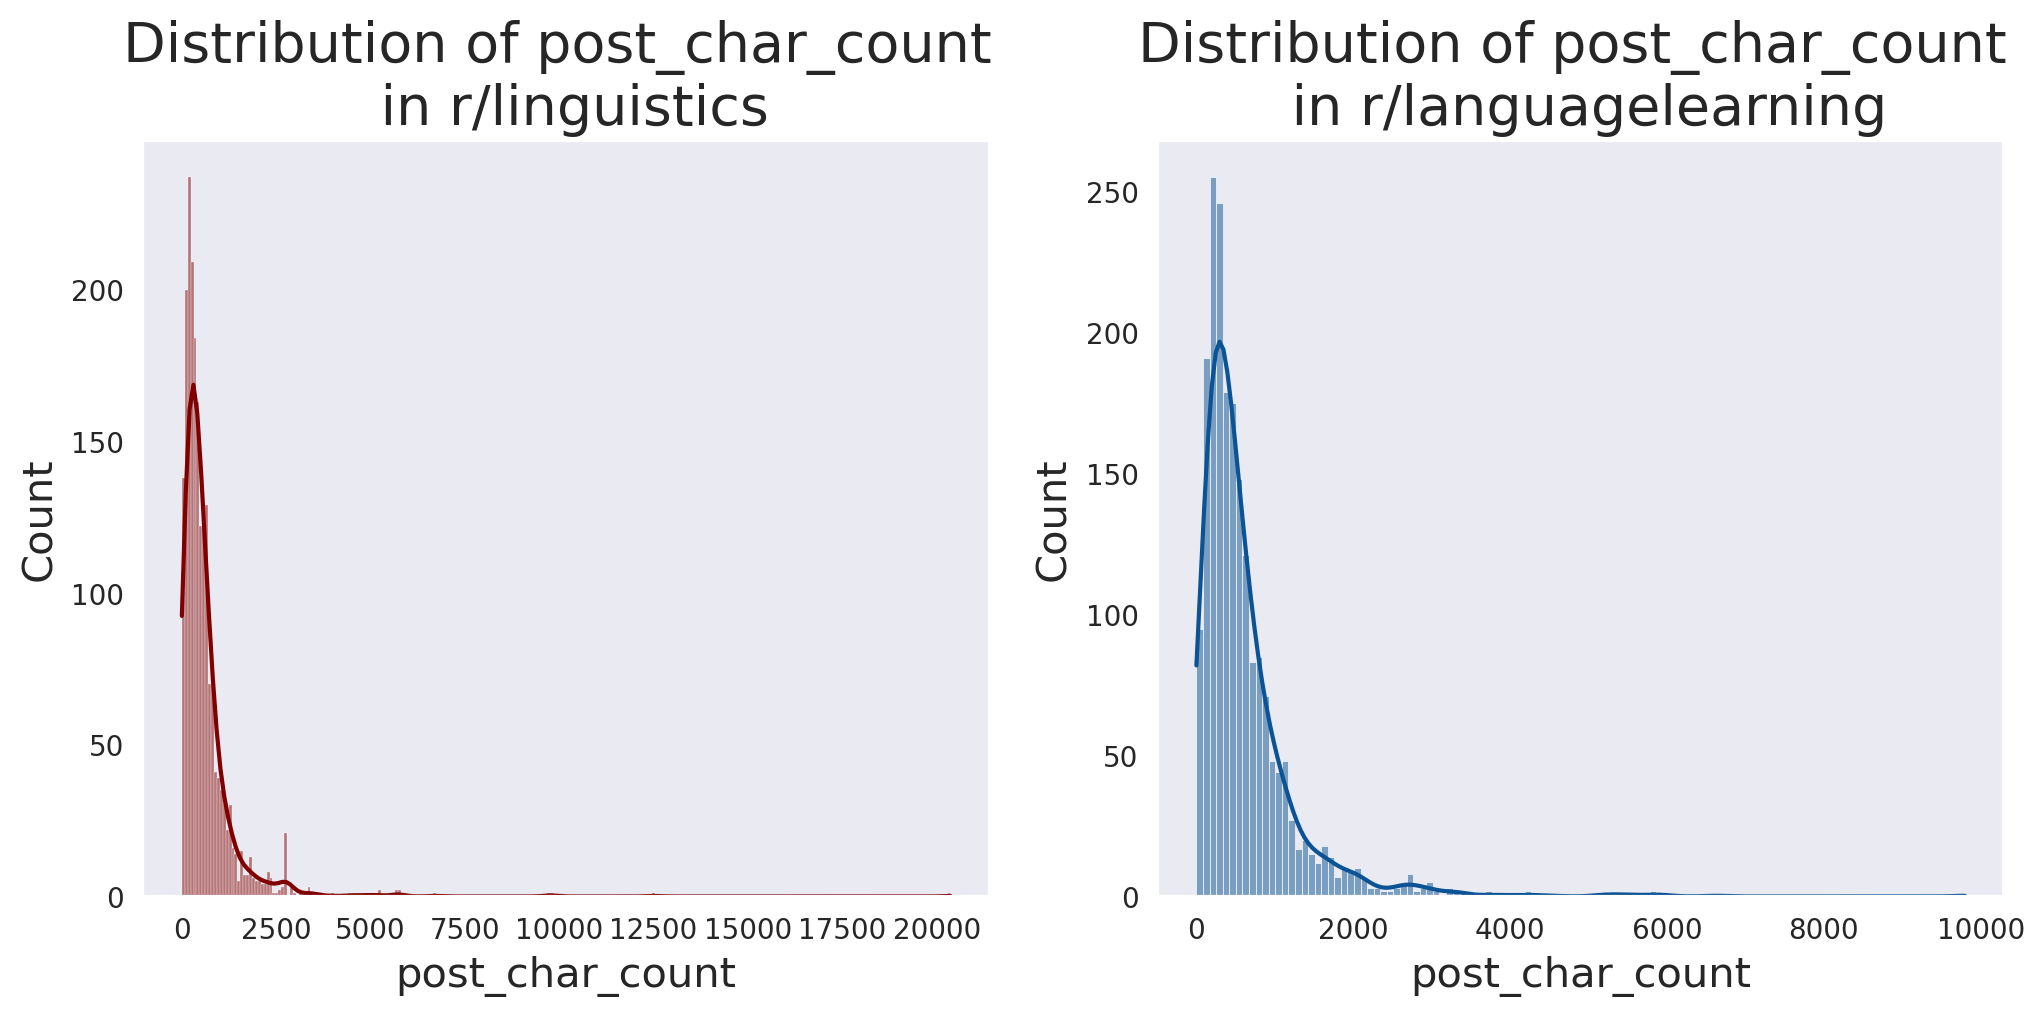

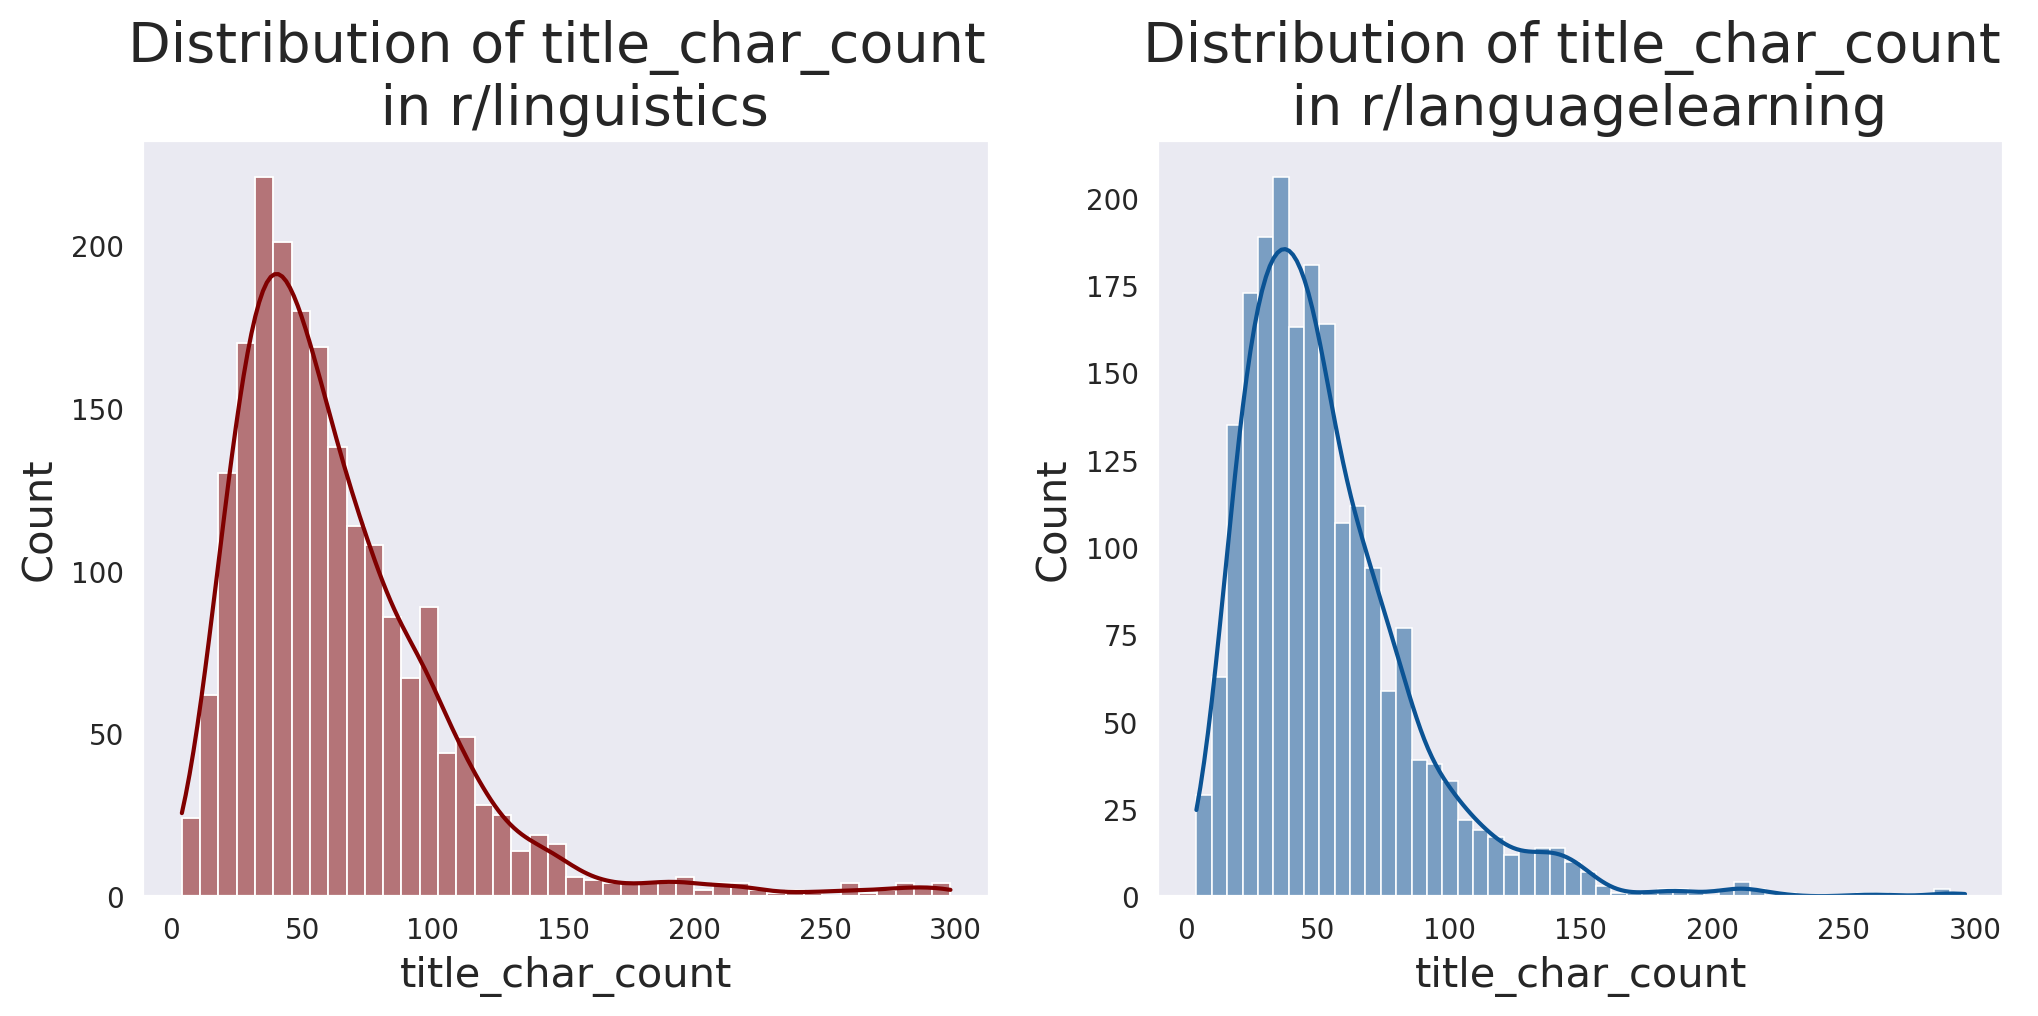

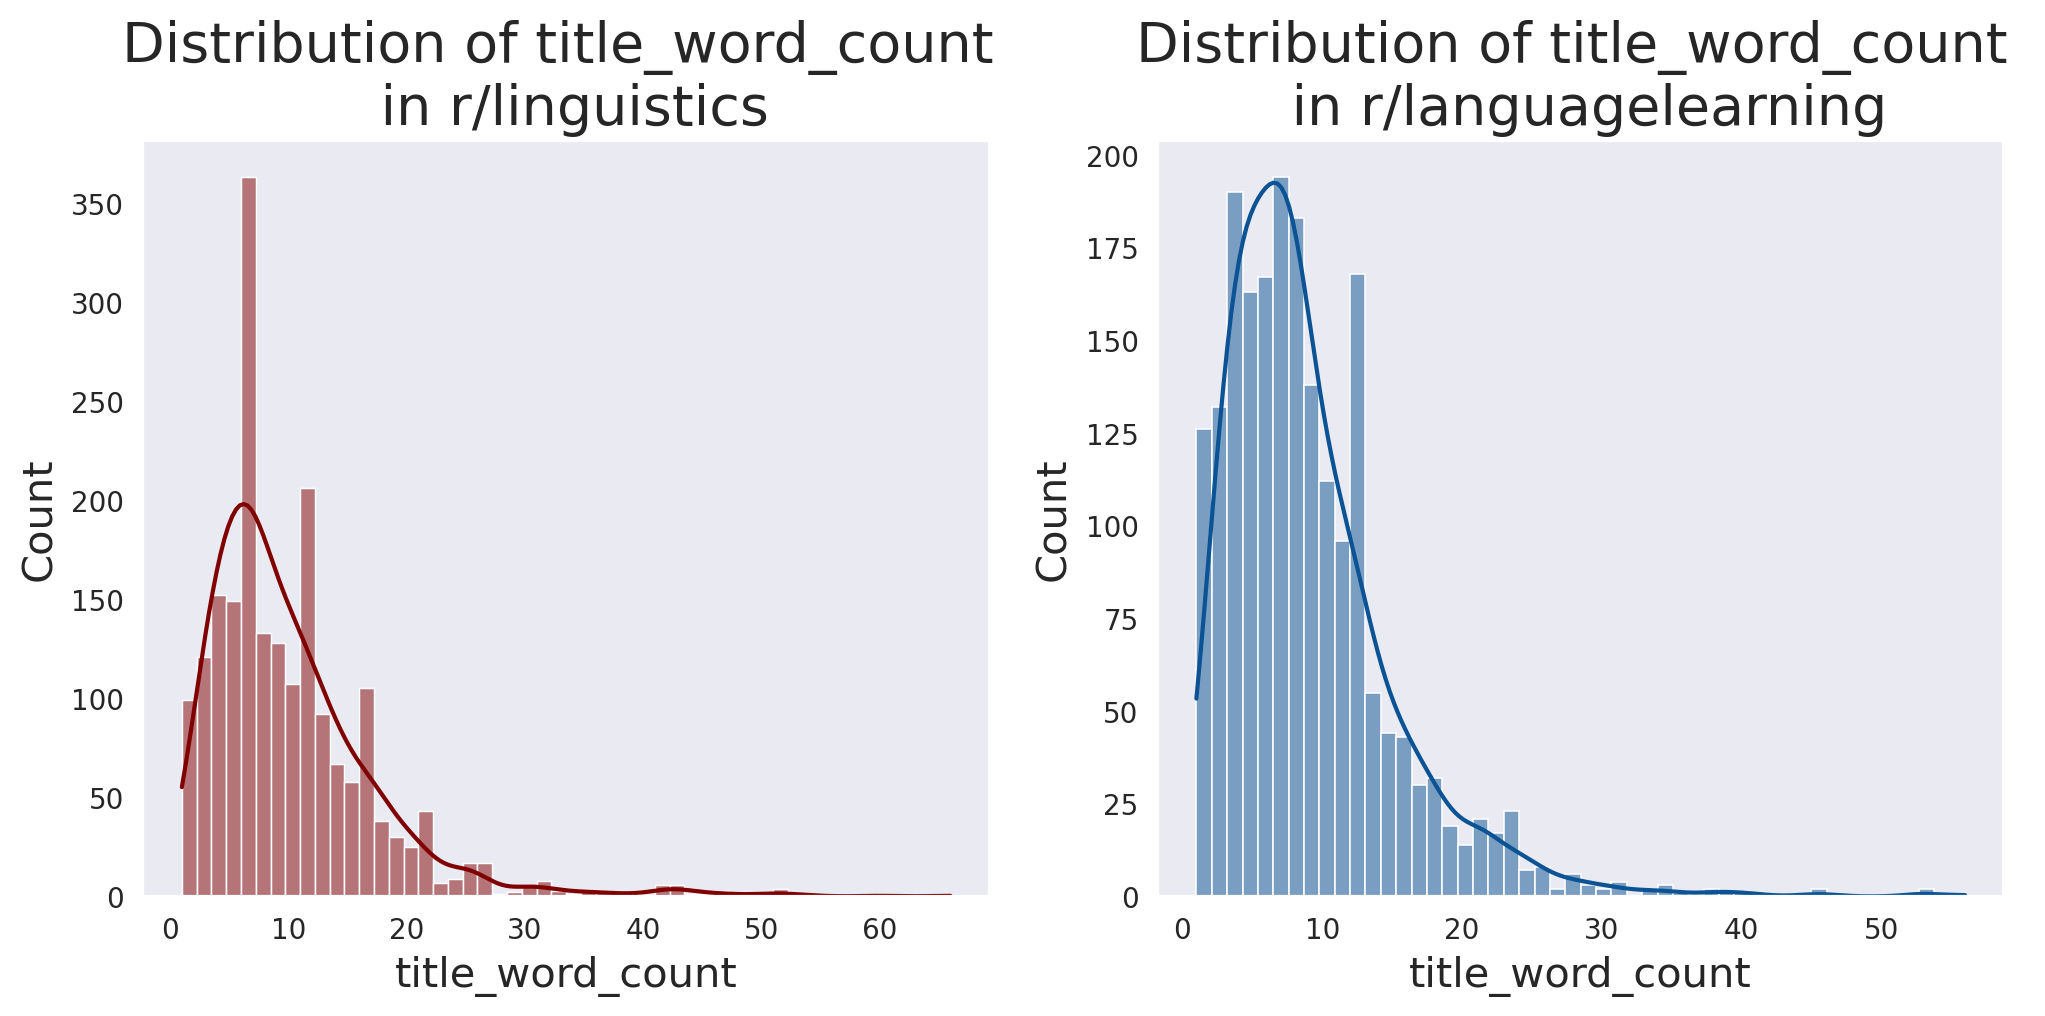

In [25]:
# distributions of the numerical features of the two subreddits

def plot_hists(col, data):
    
    fig, ax = plt.subplots(1,2,figsize = (12,5), dpi = 200)
    sns.histplot(x = data[data['subreddit'] == 'linguistics'][col], color = '#800000', kde = True, ax = ax[0])
    ax[0].set_title(f'Distribution of {col} \n in r/linguistics');
    sns.histplot(x = data[data['subreddit'] == 'languagelearning'][col], color = myblue, kde = True, ax = ax[1])
    ax[1].set_title(f'Distribution of {col} \n in r/languagelearning');

for col in ['num_comments', 'post_word_count', 'post_char_count', 'title_char_count', 'title_word_count']:
    plot_hists(col,data)



In [7]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))

#vectorizing text column and making a DataFrame with the vectors
title_vect = cv.fit_transform(data['title'])
title_vect_df = pd.DataFrame(title_vect.todense(), columns=cv.get_feature_names())

#vectorizing selftext column and making a DataFrame with the vectors
selftext_vect = cv.fit_transform(data['selftext'])
selftext_vect_df = pd.DataFrame(selftext_vect.todense(), columns=cv.get_feature_names())

for x in ['languagelearning', 'linguistics']:
    title_vect_df[data['subreddit'] == x].sum().sort_values(ascending=False).head(10)
    selftext_vect_df[data['subreddit'] == x].sum().sort_values(ascending=False).head(10)


language             590
learning             335
learn                291
english              181
languages            165
spanish              137
french                90
help                  86
german                85
language learning     85
dtype: int64

language     2159
learning     1389
like         1224
english      1197
learn        1193
just          924
know          917
spanish       916
languages     814
ve            755
dtype: int64

language       284
english        241
languages      237
does           122
words          110
linguistics    107
question        89
word            83
like            71
help            67
dtype: int64

language     1348
english      1111
like          939
languages     874
know          703
words         655
just          577
word          559
https         531
ve            502
dtype: int64

In [8]:
#oldest posts in the data
for x in ['languagelearning','linguistics']:
    data[data['subreddit'] == x]['created_utc'].min()

1625537472

1618933648